In [96]:
import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os

## Ninapro dataset

In [3]:
data_DB3_s1_E1 = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")
print(f"What kind of data structure are we working with? {type(data_DB3_s1_E1)}")
print(f"What are the keys of the data structure? \n{[key for key in data_DB3_s1_E1.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? 
['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition']


In [4]:
emg = data_DB3_s1_E1["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

EMG data dimension: (1825008, 12)
EMG data type: <class 'numpy.ndarray'>


In [5]:
## !! stimulus -> restimulus !!
emg_rectified = data_DB3_s1_E1["emg"].copy()

#Stimulus is the type of movement that is being performed
stimulus = data_DB3_s1_E1["stimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data_DB3_s1_E1["repetition"] 

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
restimulus = data_DB3_s1_E1['restimulus']
rerepetition = data_DB3_s1_E1['rerepetition']

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}, \nRestimulus {restimulus.shape}, \nRerepetition {rerepetition.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(restimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(rerepetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(np.unique(restimulus))
print(f'How many repetitions are there? {n_repetitions}') 

number_of_samples_per_trial = np.zeros((n_stimuli+1, n_repetitions))

for stimuli_idx in range(n_stimuli+1): # include the resting condition
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Nb of samples for each trial")
number_of_samples_per_trial

What are the shape of the data that we are working with? 
EMG: (1825008, 12), 
Stimulus (1825008, 1), 
Repetition (1825008, 1), 
Restimulus (1825008, 1), 
Rerepetition (1825008, 1)
How many types of movement are there? 17
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
How many repetitions are there? 5
Nb of samples for each trial


array([[125449., 110944., 120097., 122974., 123594.],
       [ 14027.,  12808.,  13026.,  13044.,  12950.],
       [ 13026.,  13082.,  13224.,  12948.,  13027.],
       [ 12969.,  12968.,  13028.,  13201.,  13026.],
       [ 12851.,  13026.,  13024.,  13029.,  12993.],
       [ 12986.,  13026.,  12950.,  13006.,  13026.],
       [ 13064.,  12969.,  12949.,  12967.,  13047.],
       [ 12970.,  13085.,  13063.,  12925.,  13028.],
       [ 13083.,  13027.,  13028.,  13026.,  13223.],
       [ 13084.,  12968.,  12986.,  12967.,  12881.],
       [  3928.,   4606.,   4409.,   4327.,   4586.],
       [ 13023.,  13005.,  13028.,  13029.,  13028.],
       [  5308.,   5364.,  12946.,   4326.,   4044.],
       [  4465.,  12968.,   4422.,   5568.,   4765.],
       [ 13025.,  12968.,  13026.,  13243.,  13005.],
       [ 13030.,   5206.,   5366.,   4509.,   4928.],
       [ 13027.,  13024.,   5467.,   7947.,   6668.],
       [  6625.,   6068.,   5690.,   5790.,   6129.]])

In [6]:
#defining the length of the moving average window
mov_mean_length = 50
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]

# time dependant windowing

# Assuming the trial duration varies
trial_duration = 8  # movement lasts for 5 sec + rest 3 sec
# Define the sampling rate
sampling_rate = 2000  # Hz (samples per second)

# Calculate the window size based on time
window_size = trial_duration * sampling_rate  # Convert duration to number of samples
window_size = 1000

# Now apply the windowing process based on this dynamically computed window_size
for stimuli_idx in range(n_stimuli+1):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        
        # Adjust the window size dynamically (depends on the duration of the trial)
        # window_weights = np.ones(window_size) / window_size  # Moving average weights
        # emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], window_weights, axis=0)

np.shape(emg_windows[0][0])


(125449, 12)

(1825008, 12)


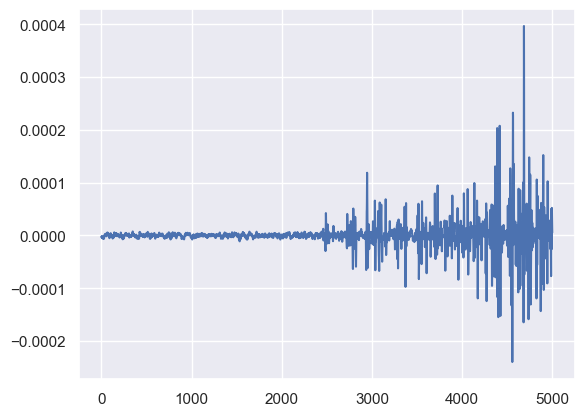

In [142]:
print(emg_rectified.shape)

plt.plot(emg_rectified[30000:35000, 0])
plt.show()

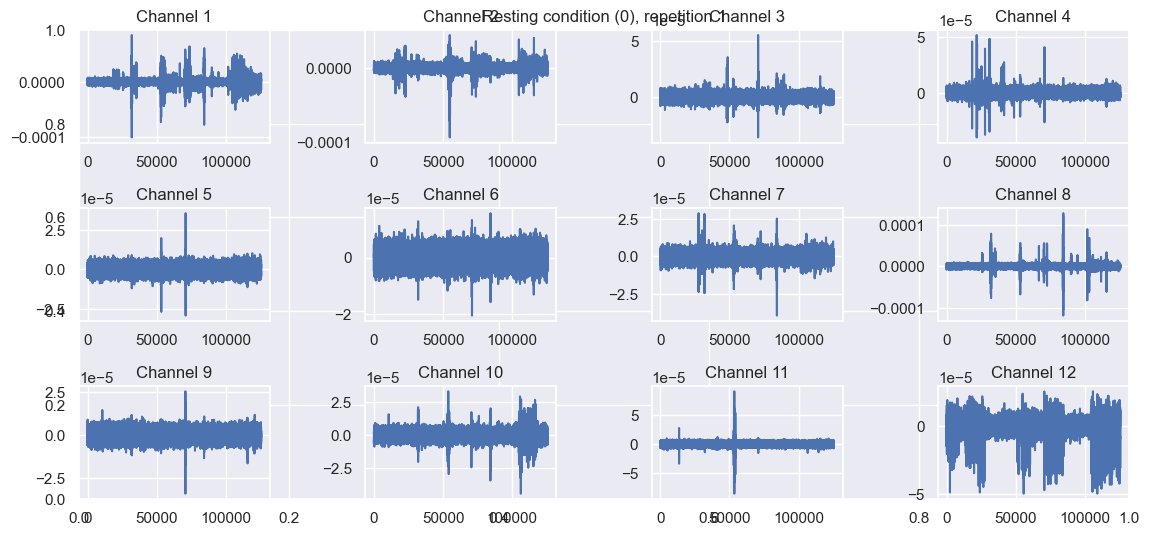

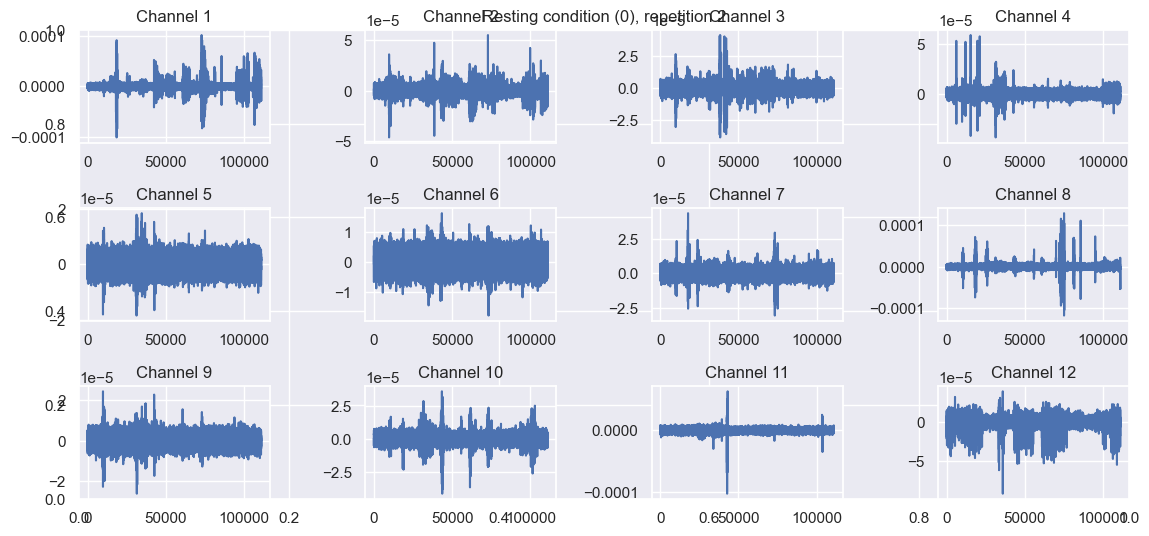

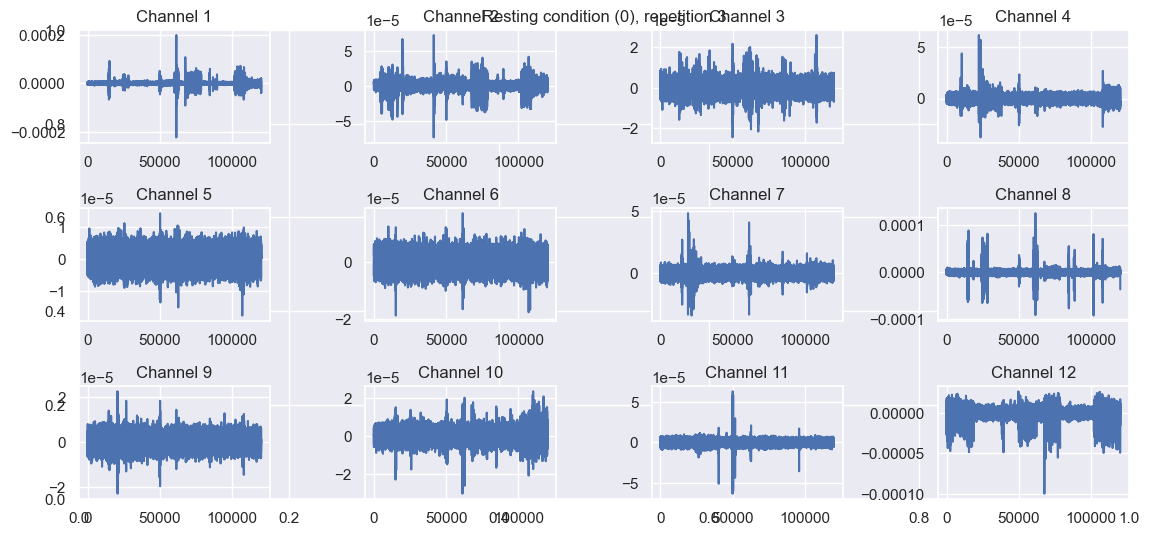

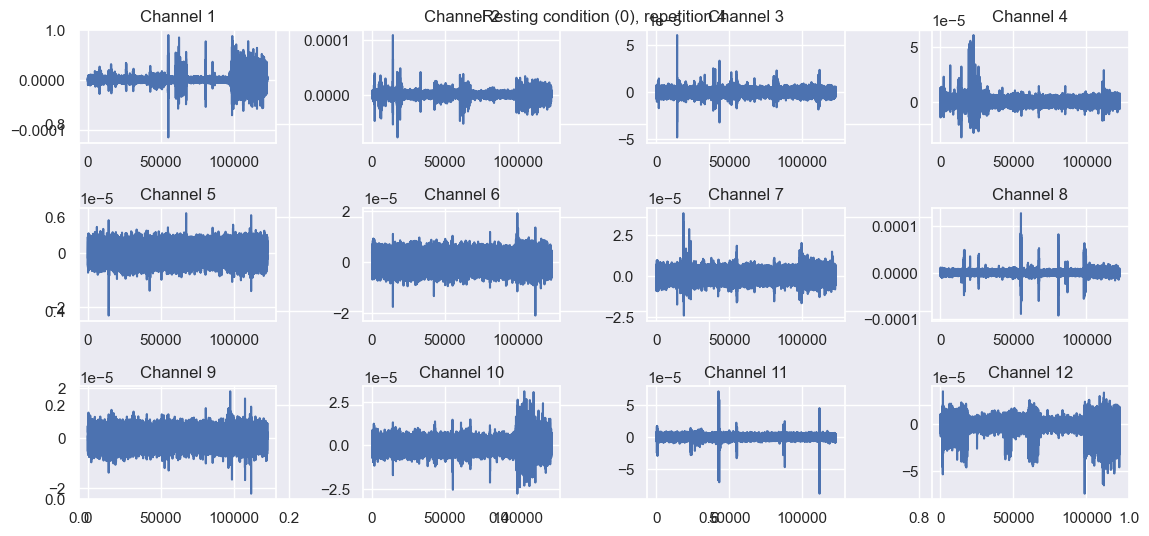

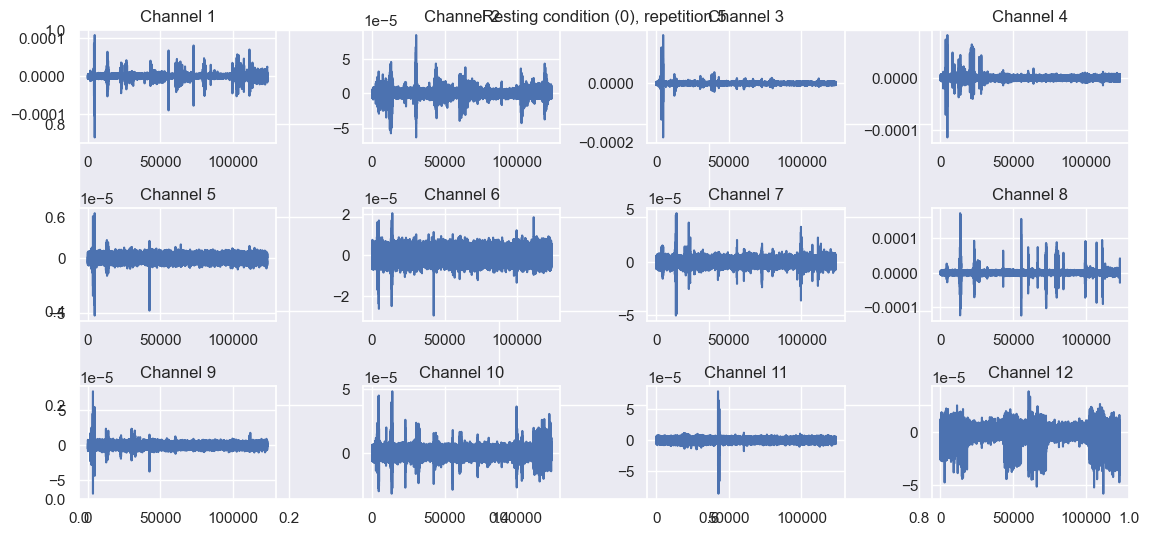

In [7]:
# Channel 1-8 : equally spaced electrodes on the forearm
# Channel 9-10 : Flexor Digitorum Superficialis and Extensor Digitorum Superficialis muscles
# Channel 11-12 : Biceps Brachii and Triceps Brachii muscles

# Plot signal for rest (0)
for rep in range(n_repetitions):
    plt.figure(figsize=(12, 6))
    plt.title(f"Resting condition (0), repetition {rep+1}")
    for channel_idx in range(n_channels): 
        plt.subplot(3, 4, channel_idx+1)
        plt.plot(emg_windows[0][rep][:, channel_idx])
        plt.title(f"Channel {channel_idx+1}")
    plt.tight_layout()
    plt.show()

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

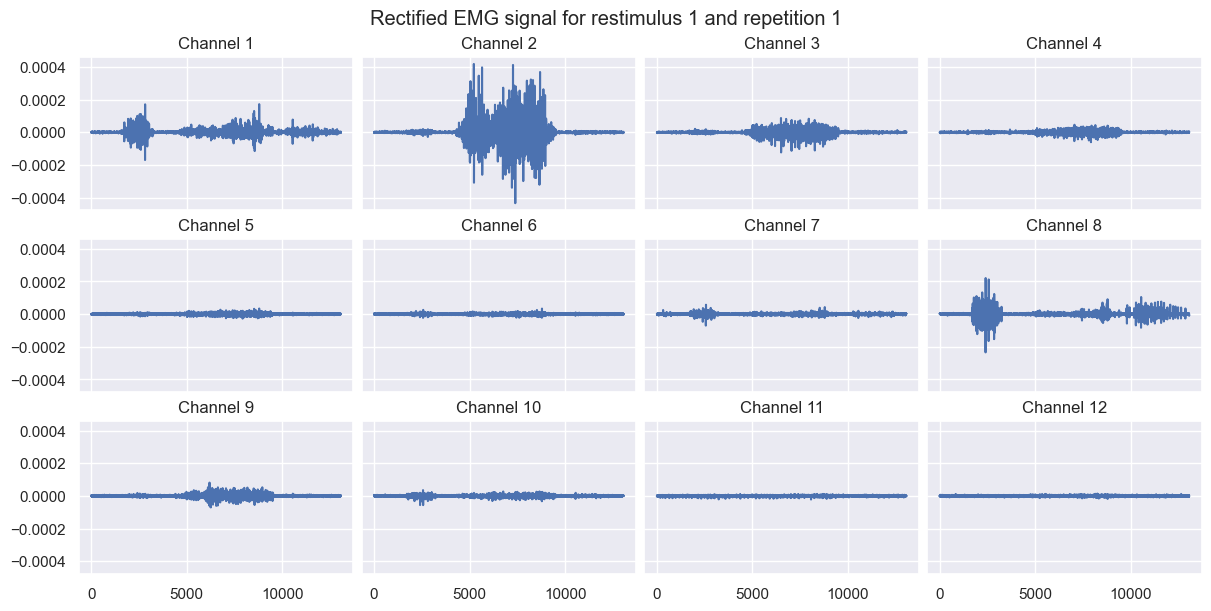

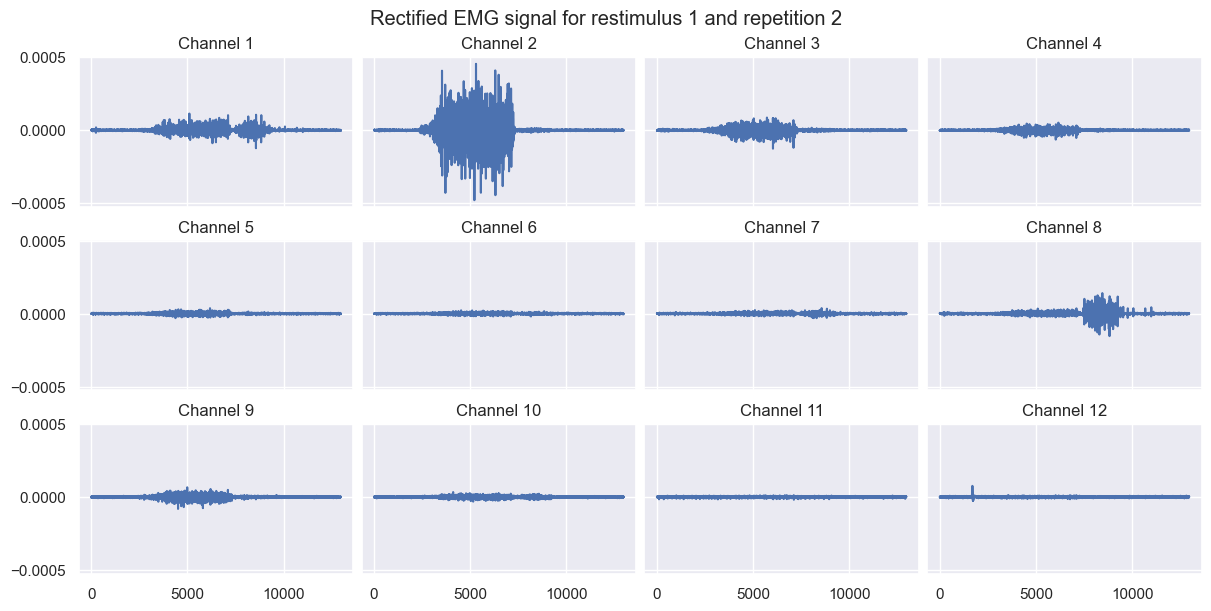

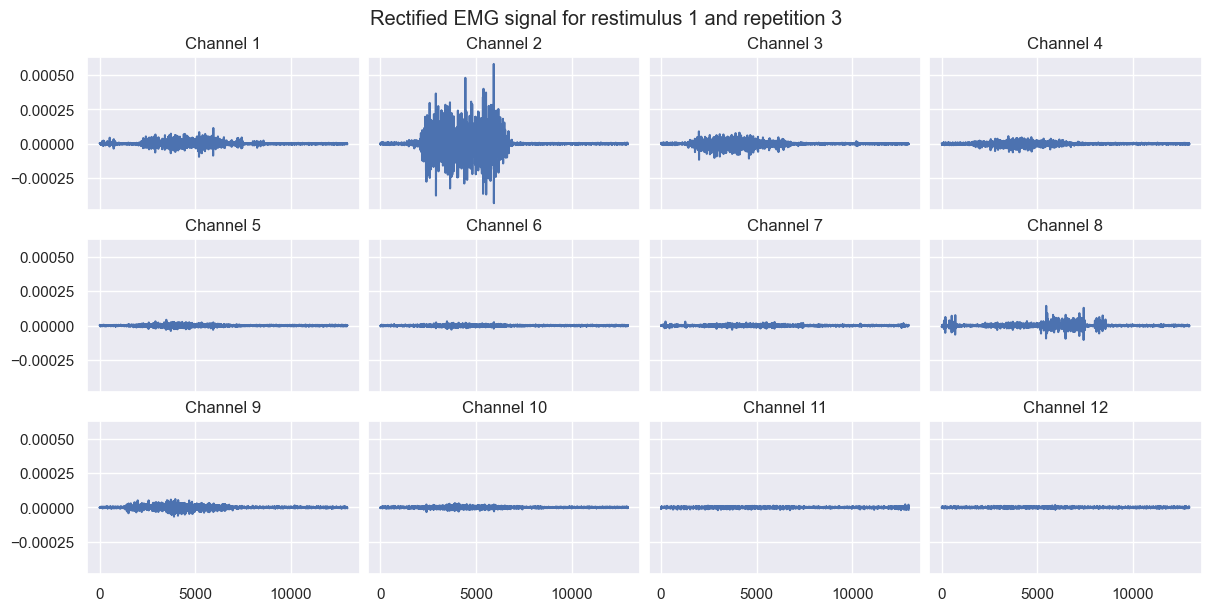

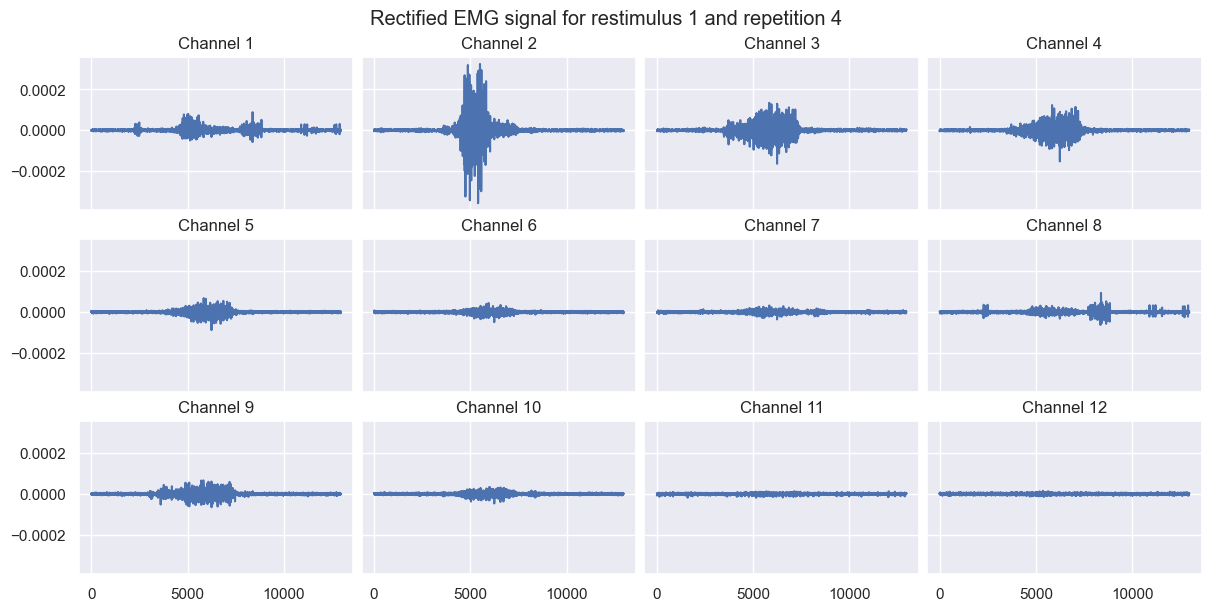

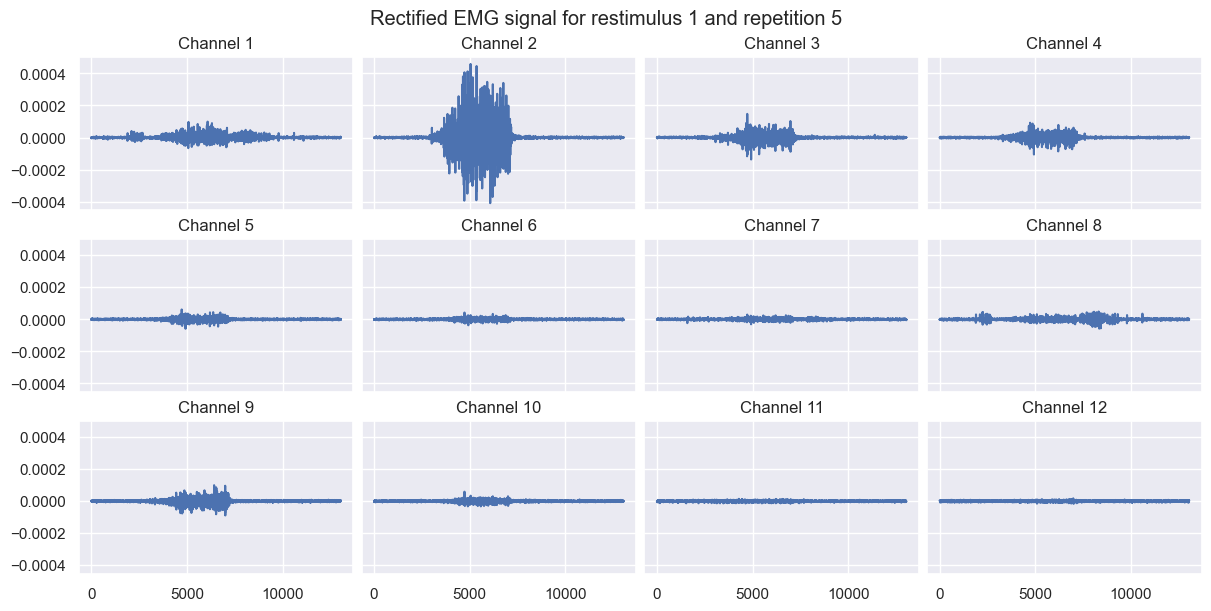

In [8]:
# Plot signal for fist action (6)


for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[6][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")


# # Envelopes
# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_envelopes[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

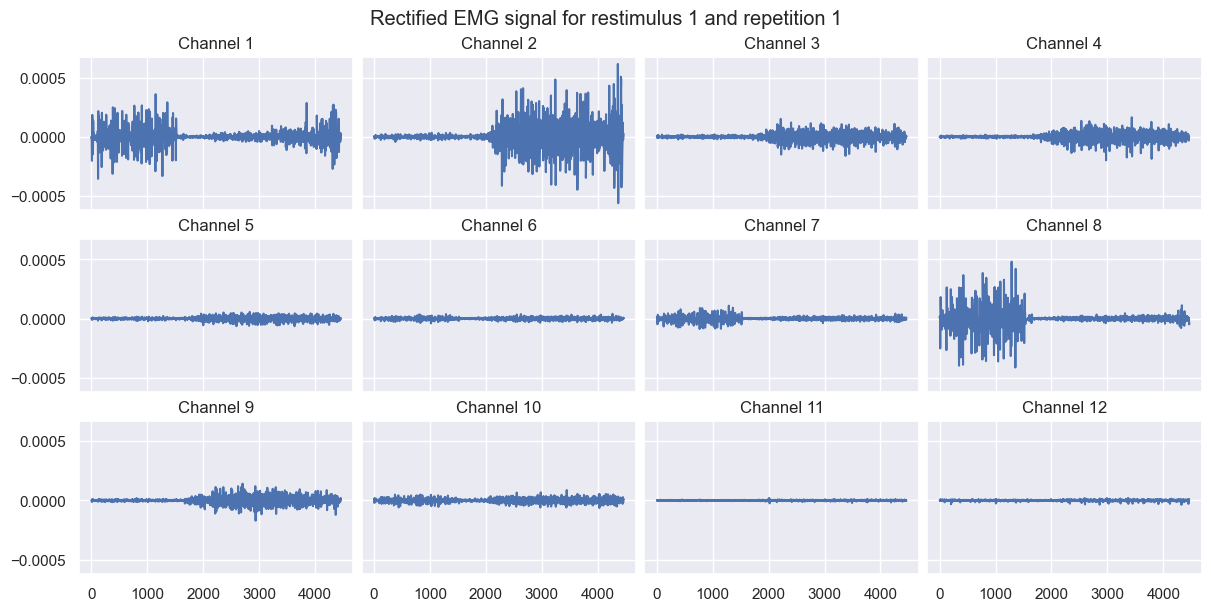

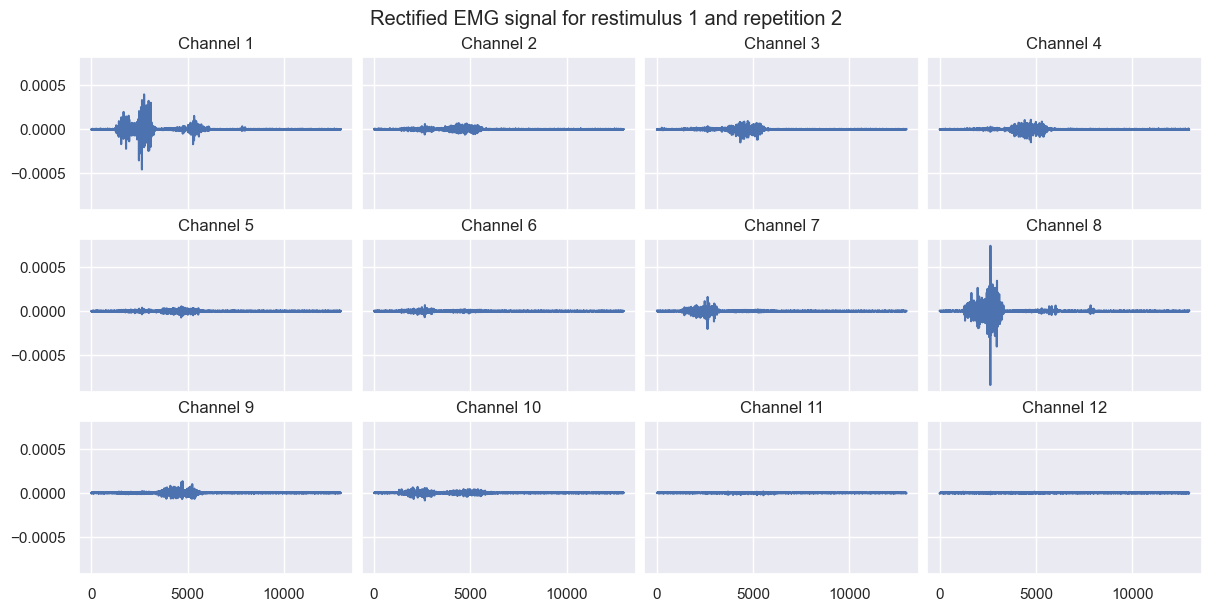

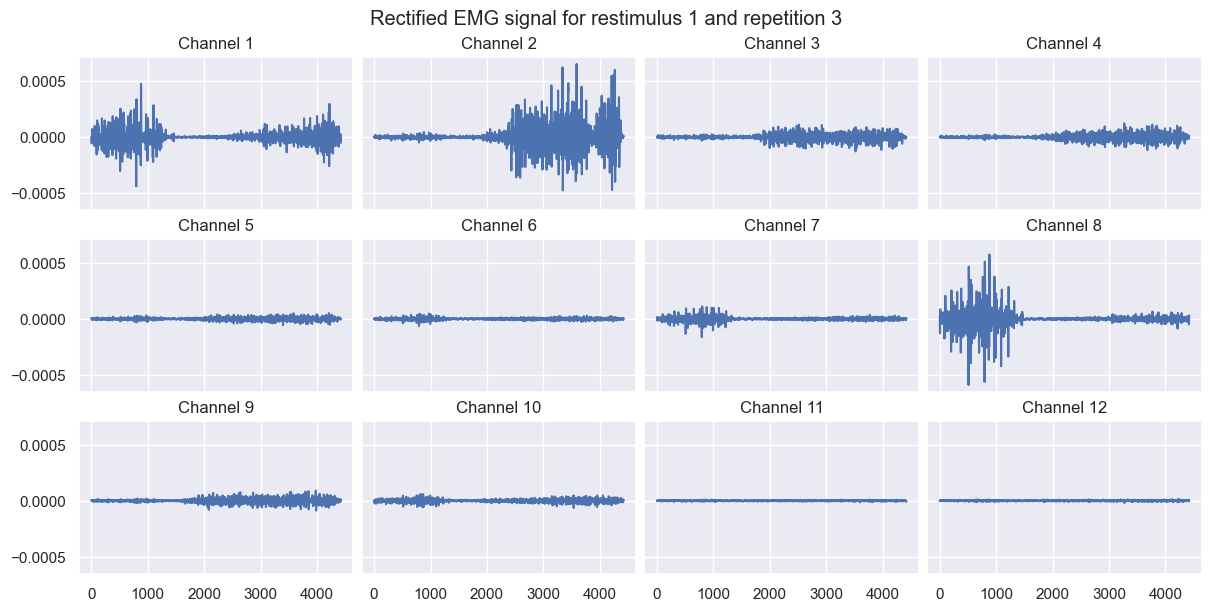

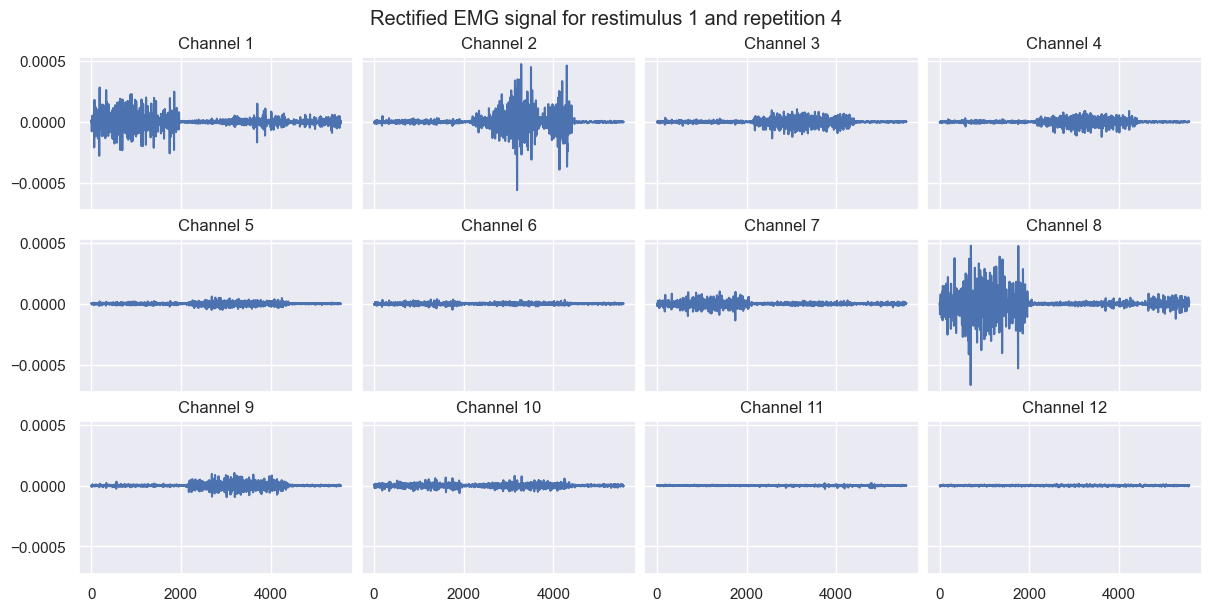

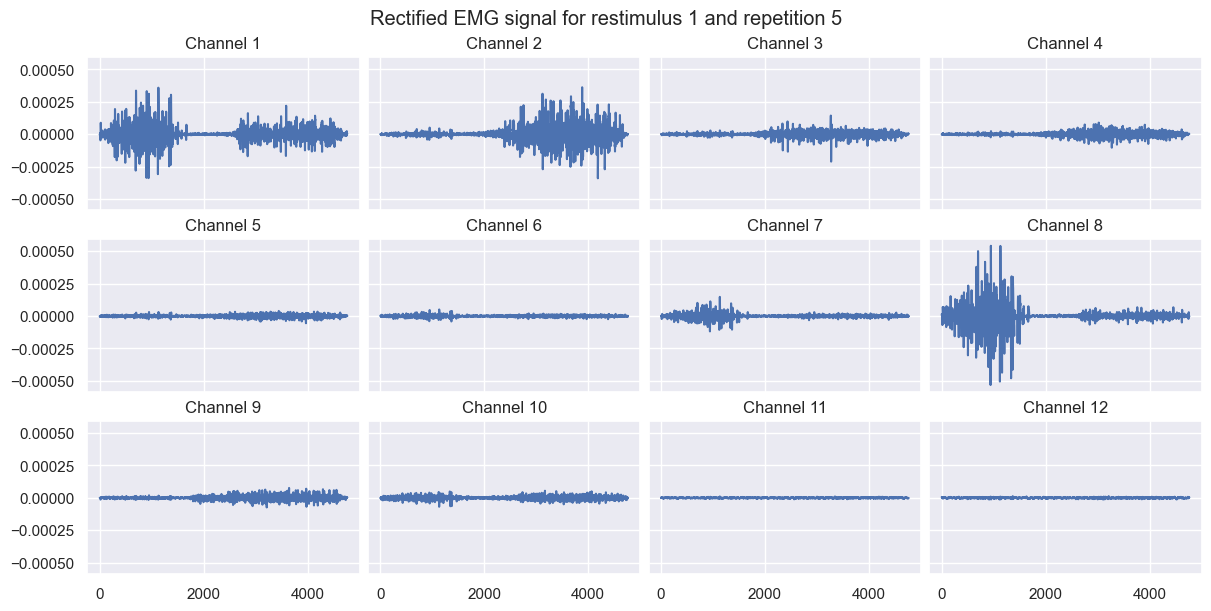

In [9]:
# Plot signal for wrist flexion action (13)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[13][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[13][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

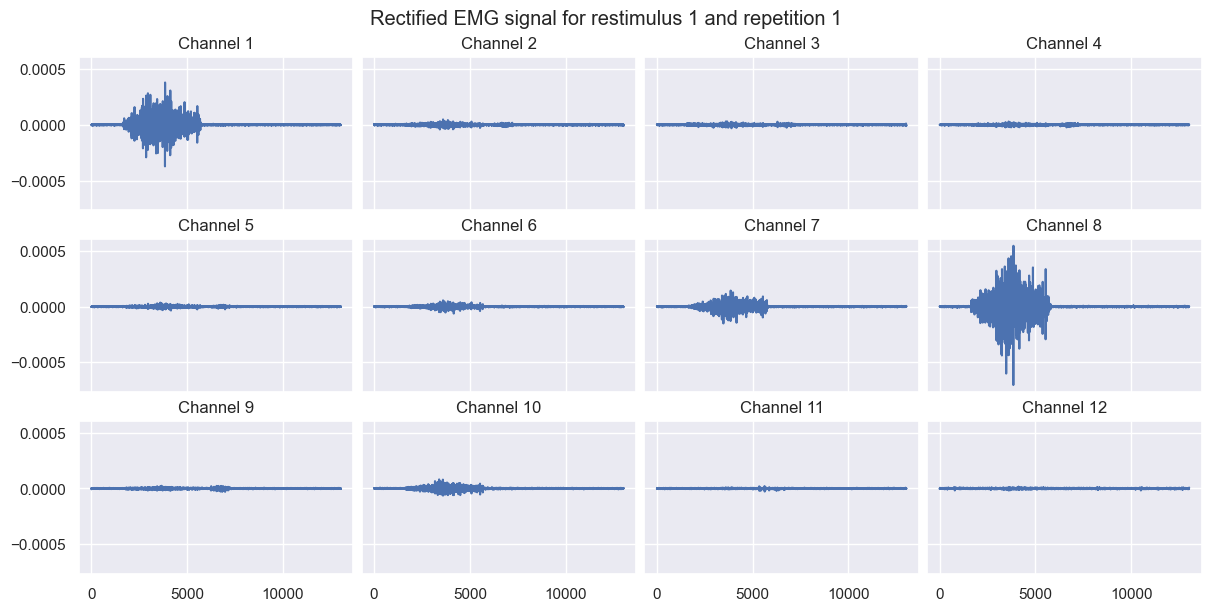

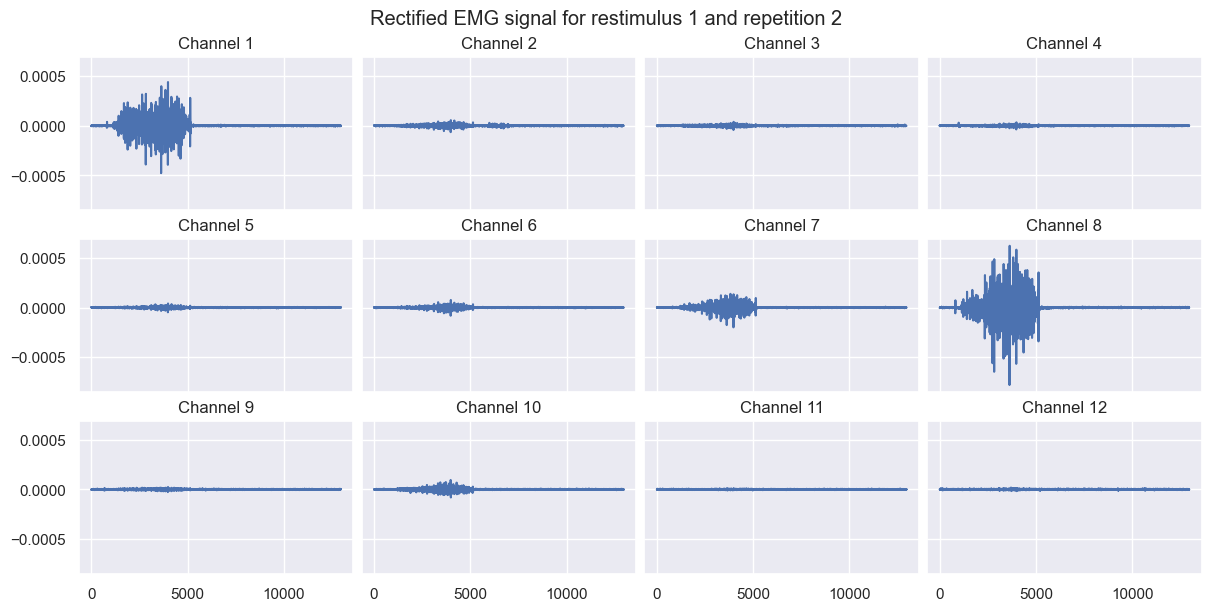

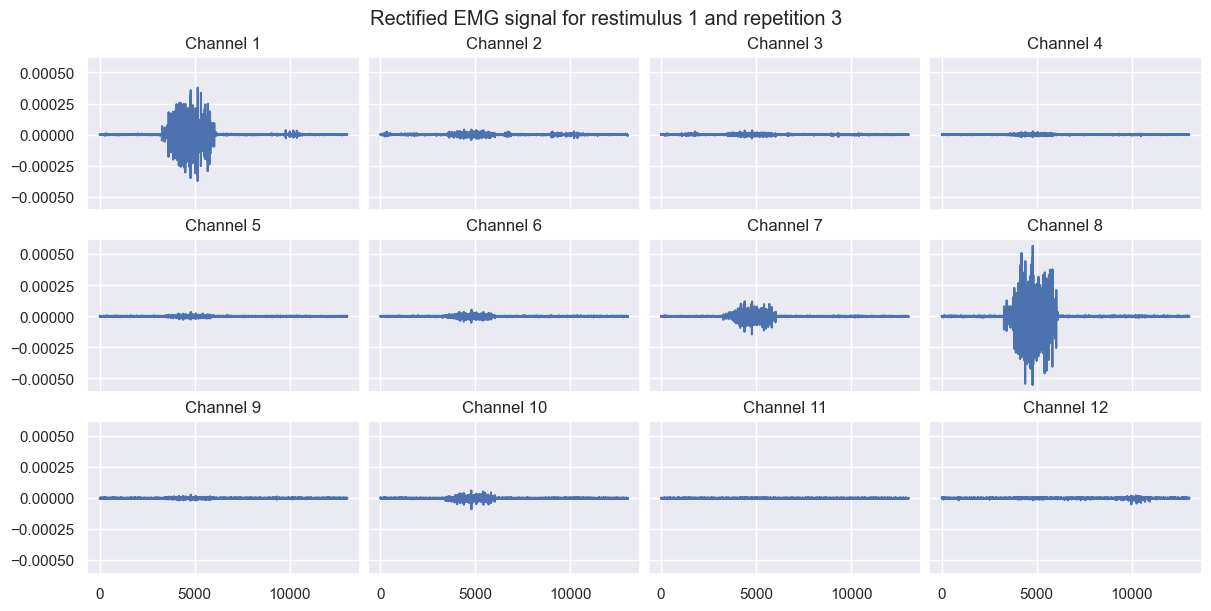

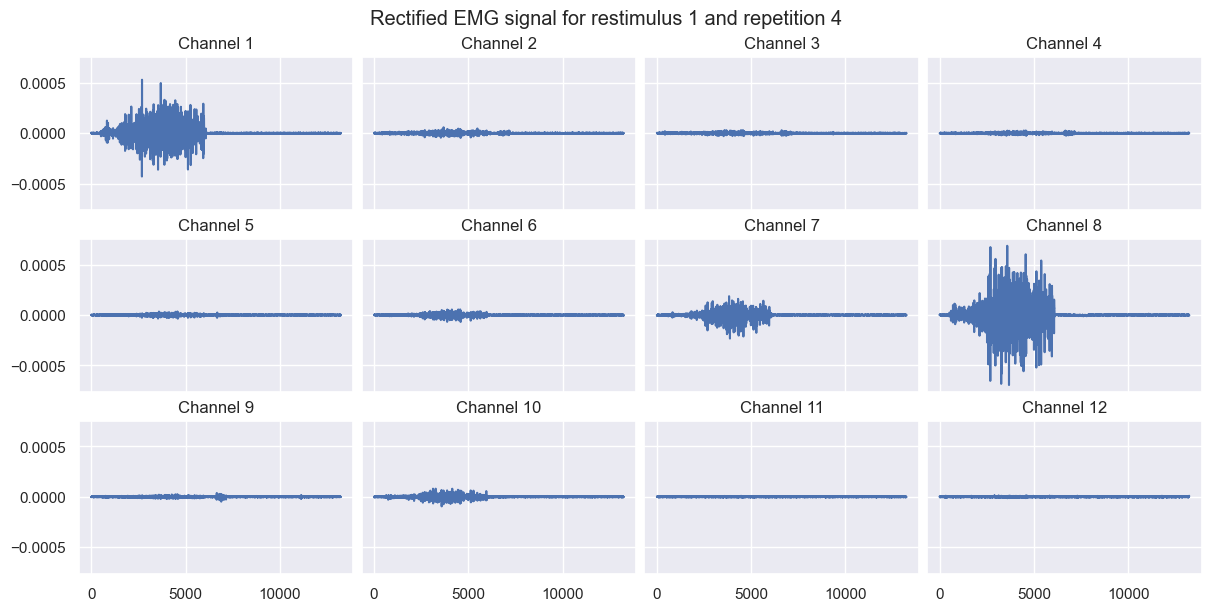

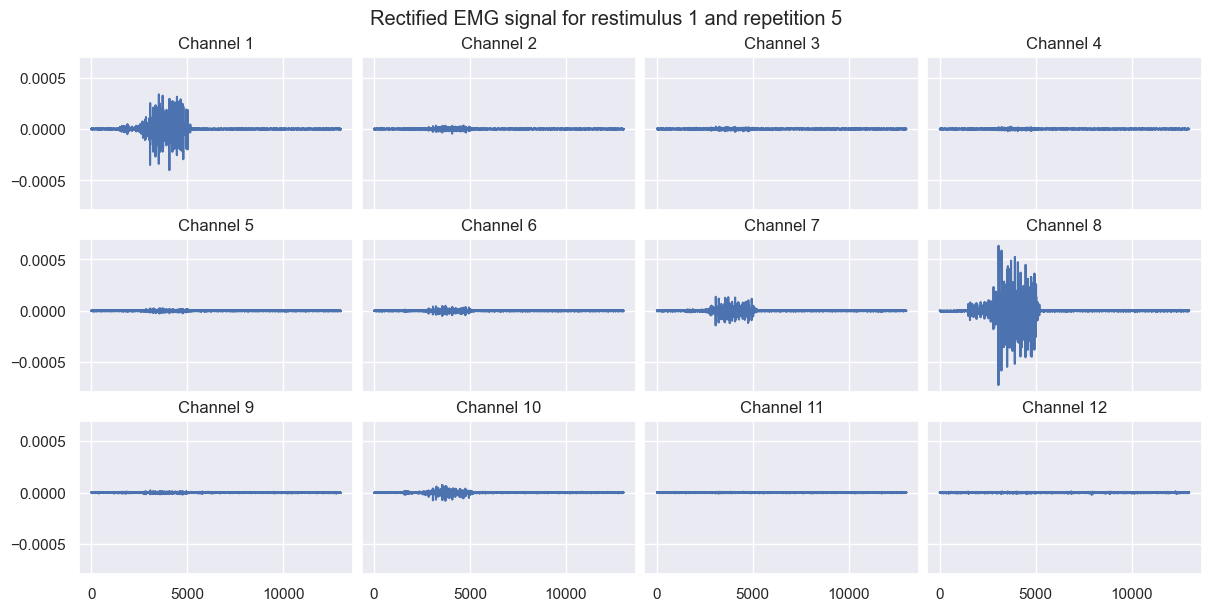

In [38]:
# Plot signal for wrist extension action (14)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[14][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[14][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")


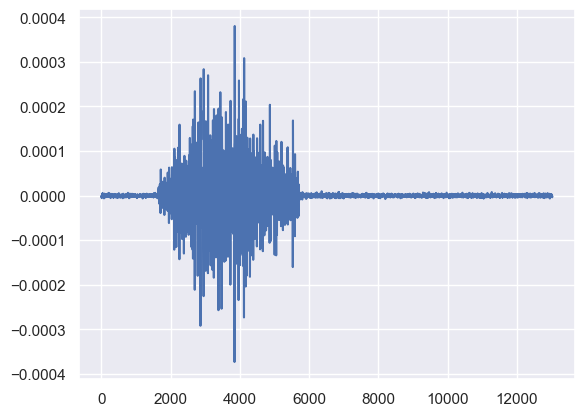

In [42]:
plt.plot(emg_windows[14][0][:, 0])
plt.show()

In [11]:
# emg_average_activations = np.zeros((n_channels, n_stimuli+1, n_repetitions))
# for stimuli_idx in range(n_stimuli+1):
#     for repetition_idx in range(n_repetitions):
#         #mean across time for each channel
#         emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

# vmin = np.min(emg_average_activations) 
# vmax = np.max(emg_average_activations)

# fig, ax = plt.subplots(9, 2, figsize=(10, 30), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# for stimuli_idx in range(n_stimuli+1):
#     sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar=True, vmin=vmin, vmax=vmax,)
#     ax[stimuli_idx].title.set_text("Restimulus " + str(stimuli_idx))
#     ax[stimuli_idx].set_xlabel("Rerepetition")
#     ax[stimuli_idx].set_ylabel("EMG channel")

## Personal data

In [12]:
data_pers = pd.read_csv("data/pers_data/cleaned/cleaned_WS_R_4_250328161002.csv")
print(f"Data shape: {data_pers.shape}")
print(f"Data columns: {data_pers.columns}")

Data shape: (71989, 5)
Data columns: Index(['Timestamp', 'Channel1', 'Channel2', 'Action1', 'Action2'], dtype='object')


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

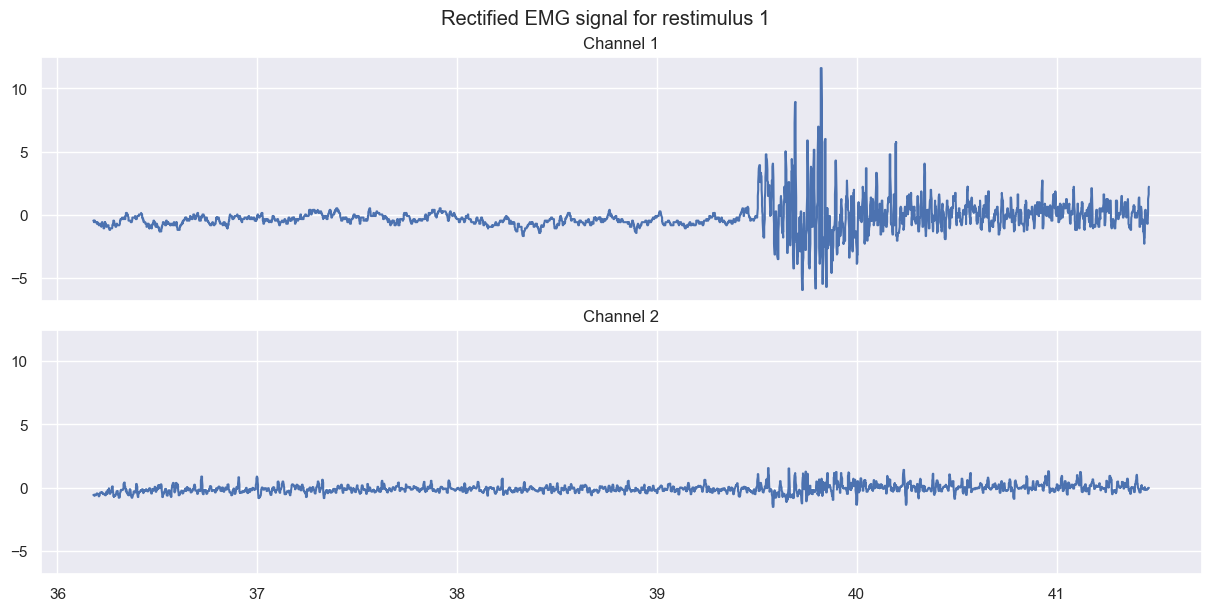

In [13]:
# Look for the first window of fist action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "Fist")].index[0]
end_id = data_pers[(data_pers["Action1"] == "Fist") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

# plt.figure(figsize=(12, 4))
# plt.plot(window_df['Timestamp'], window_df['Channel1'], label='Channel1')
# plt.plot(window_df['Timestamp'], window_df['Channel2'], label='Channel2')
# plt.title("First 'Fist' Action Window")
# plt.xlabel("Time (s)")
# plt.ylabel("Signal")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

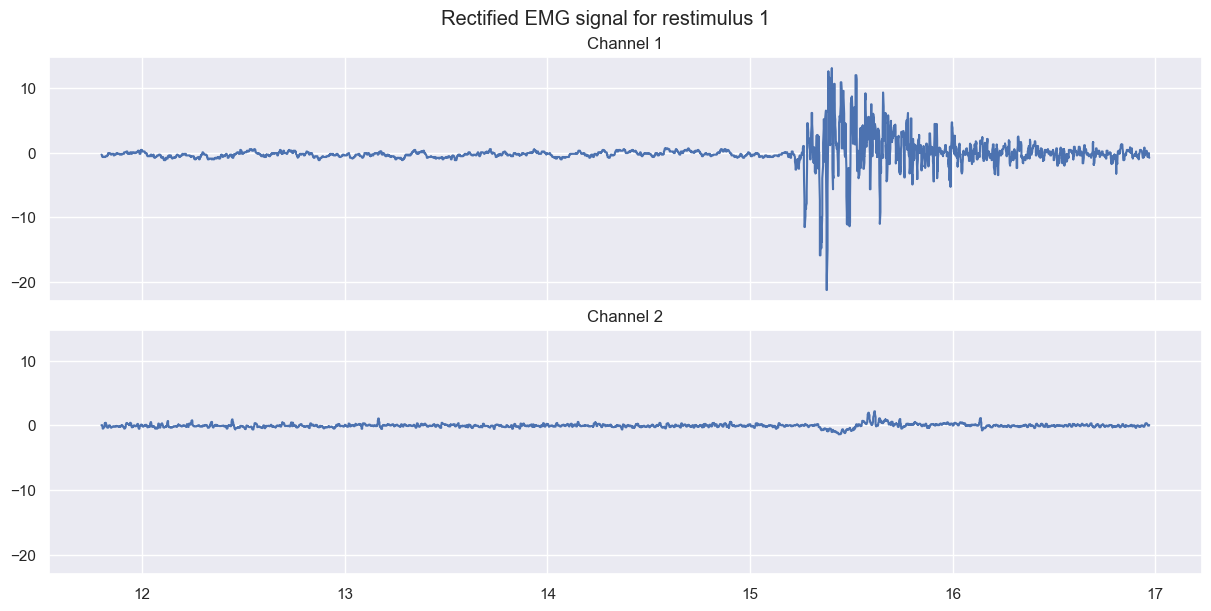

In [14]:
# Same for wrist flexion action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristFlexion")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristFlexion") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

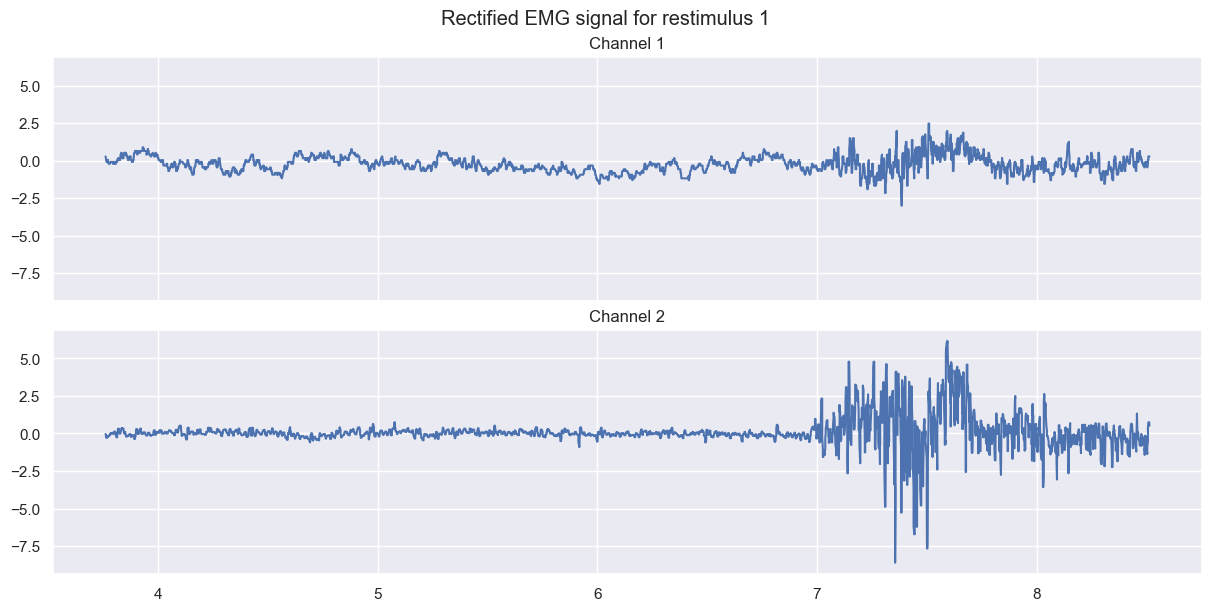

In [15]:
# Same for wrist extension action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristExt")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristExt") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")

# Correlation of channels between dataset

## Action1 + Action2 -> Gesture

In [ ]:
def compute_flat_label(row):
    if pd.isna(row['Action2']): # if Action2 is NaN, return Action1
        return row['Action1']
    elif row['Action1'] == 'Rest':
        return row['Action2']
    elif row['Action2'] == 'Rest':
        return row['Action1']
    else:
        print("Error")
        return row['Action1']  


In [74]:
# Create single label for each row
data_pers_copy = data_pers.copy()
data_pers_copy.drop(index=0, inplace=True)
data_pers_copy['Gesture'] = data_pers_copy.apply(compute_flat_label, axis=1)
data_pers_copy.drop(columns=['Action1', 'Action2'], inplace=True)

In [75]:
data_pers_copy.head()

,Timestamp,Channel1,Channel2,Gesture
1,0.161,-0.565049,-0.815220,Rest
2,0.161,-0.565049,-0.870914,Rest
3,0.162,-0.565049,-0.926608,Rest
4,0.162,-0.443307,-1.010148,Rest
5,0.162,-0.565049,-1.037995,Rest


## Resample Ninapro and personnal data at 1000Hz

In [19]:
from scipy.signal import resample
from scipy.stats import mode

def downsample_dataframe_with_labels(df, target_freq, time_col='Timestamp', label_cols=None, method='resample'):
    """
    Downsamples a DataFrame with timestamp, signal columns, and optional label columns.
    
    Parameters:
        df : pd.DataFrame
            Input data (must include a time column).
        target_freq : int
            Target sampling frequency in Hz.
        time_col : str
            Name of the time column.
        label_cols : list of str
            Columns with categorical labels (e.g., ['FlatLabel', 'Action1', 'Action2']).
        method : str
            'resample' (FFT-based) or 'average' (bin-average + mode for labels).
    
    Returns:
        pd.DataFrame
            Downsampled DataFrame with aligned time, signal, and label columns.
    """
    if time_col not in df.columns:
        raise ValueError(f"{time_col} must be in dataframe")

    label_cols = label_cols or []
    all_cols = df.columns.tolist()
    signal_cols = [col for col in all_cols if col not in [time_col] + label_cols]

    t_orig = df[time_col].values
    t_start, t_end = t_orig[0], t_orig[-1]
    duration = t_end - t_start
    n_target = int(duration * target_freq)

    # Downsample signals
    if method == 'resample':
        signals_ds = pd.DataFrame(
            resample(df[signal_cols].values, n_target),
            columns=signal_cols
        )
    elif method == 'average':
        df_indexed = df.set_index(time_col)
        df_indexed.index = pd.to_datetime(df_indexed.index, unit='s')
        signals_ds = df_indexed[signal_cols].resample(f"{int(1000/target_freq)}ms").mean().dropna().reset_index(drop=True)
    else:
        raise ValueError("method must be 'resample' or 'average'")

    # Generate new time vector
    t_uniform = np.linspace(t_start, t_end, n_target, endpoint=False)
    signals_ds.insert(0, time_col, t_uniform)

    # Downsample labels using mode per time bin
    if label_cols:
        df_label = df[[time_col] + label_cols].copy()
        df_label.index = pd.to_datetime(df_label[time_col], unit='s')

        bin_size_ms = int(1000 / target_freq)
        label_resampled = []

        for col in label_cols:
            grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            label_resampled.append(grouped)

        label_df = pd.concat(label_resampled, axis=1)
        label_df.columns = label_cols
        label_df = label_df.dropna().reset_index(drop=True)

        # Align label_df to signal df
        label_df = label_df.iloc[:len(signals_ds)]
        signals_ds[label_cols] = label_df

    return signals_ds


In [20]:
downsampled_data_pers = downsample_dataframe_with_labels(data_pers_copy, target_freq=1000, time_col='Timestamp', label_cols=['Gesture'], method='resample')
downsampled_data_pers.head()

,Timestamp,Channel1,Channel2,Gesture
0,0.161,-0.504602,-0.670395,Rest
1,0.162,-0.586215,-0.944057,Rest
2,0.163,-0.473983,-0.969143,Rest
3,0.164,-0.563936,-1.079206,Rest
4,0.165,-0.572229,-1.144015,Rest


In [21]:
np.shape(data_DB3_s1_E1['emg'])

(1825008, 12)

In [22]:
# Create an empty DataFrame to store the data
data_ninapro = pd.DataFrame()

for channel in range(n_channels):
    data_ninapro[f'Channel{channel+1}'] = emg_rectified[:, channel].flatten()
data_ninapro['Stimulus'] = stimulus.flatten()
data_ninapro['Repetition'] = repetition.flatten()
data_ninapro['Restimulus'] = restimulus.flatten()
data_ninapro['Rerepetition'] = rerepetition.flatten()

sampling_rate = 2000  # Hz (samples per second)
n_samples = data_ninapro.shape[0]
data_ninapro['Timestamp'] = np.arange(n_samples) / sampling_rate  # Create a timestamp column


In [23]:
data_ninapro.head()

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
0,0.000004,-2.786037e-07,-0.000005,-6.351953e-07,-1.512986e-07,0.000001,-1.483299e-06,-0.000004,2.491953e-06,-0.000004,1.612457e-06,4.699033e-06,0,0,0,1,0.0000
1,0.000005,-1.285415e-06,-0.000003,7.074447e-07,-3.191196e-07,-0.000002,-6.441234e-07,-0.000004,2.827591e-06,-0.000004,1.276554e-06,3.524141e-06,0,0,0,1,0.0005
2,0.000004,-3.970727e-06,-0.000003,7.072846e-07,-1.494141e-06,-0.000003,5.308528e-07,-0.000004,2.156130e-06,-0.000006,1.276352e-06,1.509949e-06,0,0,0,1,0.0010
3,0.000003,-4.306138e-06,-0.000004,3.572455e-08,-3.004762e-06,-0.000003,8.665290e-07,-0.000004,-1.938318e-07,-0.000005,1.779749e-06,5.028567e-07,0,0,0,1,0.0015
4,0.000003,-6.131493e-07,-0.000003,-1.322356e-07,-3.508384e-06,-0.000004,6.986052e-07,-0.000003,-2.543793e-06,-0.000003,6.045457e-07,2.181365e-06,0,0,0,1,0.0020


In [24]:
# data_ninapro_copy = data_ninapro.copy()
# downsampled_data_ninapro = downsample_dataframe_with_labels(data_ninapro_copy, target_freq=1000, time_col='Timestamp', label_cols=['Stimulus', 'Repetition', 'Restimulus', 'Rerepetition'], method='resample')
# downsampled_data_ninapro.head()

In [25]:
# downsampled_data_ninapro.to_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv", index=False)

In [26]:
downsampled_data_ninapro = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
downsampled_data_ninapro.head()

,Timestamp,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition
0,0.000,0.000004,3.421130e-07,-0.000004,-7.395218e-07,-1.648205e-07,-0.000001,-2.462329e-06,-0.000003,2.178590e-06,-0.000005,9.750480e-07,8.729874e-07,0,0,0,1
1,0.001,0.000004,-4.112867e-06,-0.000004,8.034041e-07,-1.258258e-06,-0.000002,7.390273e-07,-0.000005,2.081342e-06,-0.000005,1.550235e-06,2.855237e-06,0,0,0,1
2,0.002,0.000003,-8.064127e-07,-0.000003,-2.994702e-07,-3.919208e-06,-0.000004,4.794938e-07,-0.000003,-2.425310e-06,-0.000003,6.500644e-07,7.891234e-07,0,0,0,1
3,0.003,0.000004,2.282617e-06,-0.000003,-1.401341e-07,-4.994414e-07,-0.000003,5.482524e-07,-0.000004,5.588637e-08,-0.000001,-8.470170e-07,4.445305e-06,0,0,0,1
4,0.004,0.000004,2.605559e-06,-0.000005,-7.612063e-07,-2.968801e-06,-0.000004,3.764431e-06,-0.000006,6.121387e-06,-0.000001,7.550654e-07,5.035874e-06,0,0,0,1


length of stimulus 1 for repetition 1,2,3,4: 6031 5433 5530 5561
length of restimulus 1 for repetition 1,2,3,4: 7013 6404 6512 6522


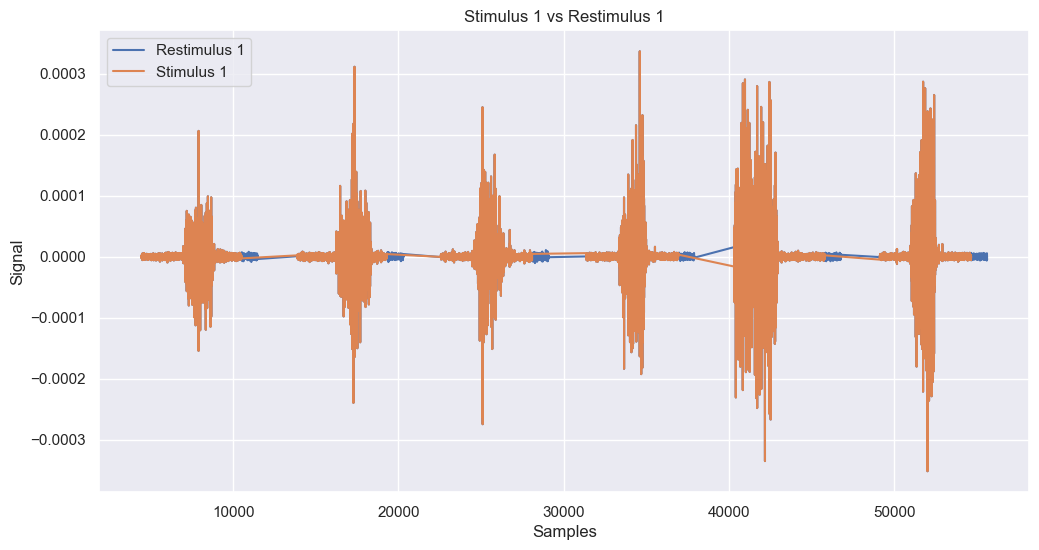

In [27]:
downsampled_data_ninapro.Stimulus.unique()
downsampled_data_ninapro.Restimulus.unique()

stim_1 = downsampled_data_ninapro[downsampled_data_ninapro['Stimulus'] == 1]["Channel1"]
restim_1 = downsampled_data_ninapro[downsampled_data_ninapro['Restimulus'] == 1]["Channel1"]
rep_1 = downsampled_data_ninapro[downsampled_data_ninapro['Repetition'] == 1]["Channel1"]
rerep_1 = downsampled_data_ninapro[downsampled_data_ninapro['Rerepetition'] == 1]["Channel1"]


# plot stim_1 and restim_1
plt.figure(figsize=(12, 6))
plt.plot(restim_1, label='Restimulus 1')
plt.plot(stim_1, label='Stimulus 1')
# plt.plot(rep_1, label='Repetition 1')
# plt.plot(rerep_1, label='Rerepetition 1')
plt.title("Stimulus 1 vs Restimulus 1")
plt.xlabel("Samples")
plt.ylabel("Signal")
plt.legend()


stim_1_r1 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 1")["Channel1"]
stim_1_r2 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 2")["Channel1"]
stim_1_r3 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 3")["Channel1"]
stim_1_r4 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 4")["Channel1"]

print("length of stimulus 1 for repetition 1,2,3,4:", len(stim_1_r1), len(stim_1_r2), len(stim_1_r3), len(stim_1_r4))

restim_1_r1 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 1")["Channel1"]
restim_1_r2 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 2")["Channel1"]
restim_1_r3 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 3")["Channel1"]
restim_1_r4 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 4")["Channel1"]

print("length of restimulus 1 for repetition 1,2,3,4:",len(restim_1_r1), len(restim_1_r2), len(restim_1_r3), len(restim_1_r4))


## Correlation between channels

In [28]:
# Map personnal labels to Ninapro labels

# id_to_gesture
movement_ExA = {
    0: "Rest",
    1: "IndexFlex",
    3: "MiddleFlex",
    5: "RingPinkyFlex",
    7: "RingPinkyFlex",
    9: "ThumbAdd",
    10: "ThumbAbd",
    11: "ThumbFlex",
}

movement_ExB = {
    0: "Rest",
    1: "ThumbUp",
    2: "Scisors",
    5: "Palm",
    6: "Fist",
    9: "WristRotIn",
    10: "WristRotExt",
    13: "WristFlexion",
    14: "WristExt",
}

movement_ExC = {
    0: "Rest",
    1: "CylindGraspClosed",
    2: "CylindGraspClosed",
    3: "HookGraspClosed",
    14: "PinchGraspClosed",
    15: "PinchGraspClosed",
    19: "LumbGraspClosed",
}

pers_gestures = {"Rest", "Fist", "WristFlexion", "WristExt", "WristRotIn", "WristRotExt", "Palm"}

gesture_to_id = {v: k for k, v in movement_ExB.items() if v in pers_gestures}
gesture_to_id

{'Rest': 0,
 'Palm': 5,
 'Fist': 6,
 'WristRotIn': 9,
 'WristRotExt': 10,
 'WristFlexion': 13,
 'WristExt': 14}

In [29]:
# Channel 1 pers data -> Channel 2 ninapro
# Channel 2 pers data -> Channel 8 ninapro

# --> train classifier on Ninapro data (2 & 8) and test on personal data (1 & 2)

## Model

In [30]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    print(f"Number of samples: {n_samples}, Number of features: {n_features}, Number of channels: {n_channels}")
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0

            # Select the time steps corresponding to the current stimulus and repetition
            
            selected_tsteps = np.logical_and(stimulus == stimulus.unique()[i], repetition == repetition.unique()[j]).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result

                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [ ]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
# Frequency domain features (FFT-based)
fft_values = lambda x: np.fft.fft(x, axis=0)
fft_magnitude = lambda x: np.abs(fft_values(x))
fft_power = lambda x: np.square(fft_magnitude(x))
freqs = lambda x: np.fft.fftfreq(x.shape[0], d=1/1000)  # Assuming a sampling rate of 1000 Hz

total_power = lambda x: np.sum(fft_power(x), axis=0)  # Total power
mean_freq = lambda x: np.sum(freqs(x) * fft_power(x), axis=0) / np.sum(fft_power(x), axis=0)  # Mean frequency
median_freq = lambda x: np.median(freqs(x) * fft_power(x), axis=0)  # Median frequency
peak_freq = lambda x: freqs(x)[np.argmax(fft_power(x), axis=0)]  # Peak frequency

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)

features_selected = [mav, std, maxav, rms, wl, ssc]

In [ ]:
# From array to dataframe
data = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")
# data = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
sampling_rate=2000 # Hz (samples per second)

data_ninapro_df = pd.DataFrame(data_ninapro, columns=[f'Channel{i+1}' for i in range(n_channels)] + ['Stimulus', 'Repetition', 'Restimulus', 'Rerepetition'])
for channel in range(n_channels):
    data_ninapro_df[f'Channel{channel+1}'] = data['emg'][:, channel].flatten()
data_ninapro_df['Stimulus'] = data["stimulus"]
data_ninapro_df['Repetition'] = data["repetition"]
data_ninapro_df['Restimulus'] = data["restimulus"]
data_ninapro_df['Rerepetition'] = data["rerepetition"]
data_ninapro_df['Timestamp'] = np.arange(data_ninapro_df.shape[0]) / sampling_rate  # Create a timestamp column

data_ninapro_df.head() # warning this is not the downsampled dataset (take the one from next cell)

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
0,0.000004,-2.786037e-07,-0.000005,-6.351953e-07,-1.512986e-07,0.000001,-1.483299e-06,-0.000004,2.491953e-06,-0.000004,1.612457e-06,4.699033e-06,0,0,0,1,0.0000
1,0.000005,-1.285415e-06,-0.000003,7.074447e-07,-3.191196e-07,-0.000002,-6.441234e-07,-0.000004,2.827591e-06,-0.000004,1.276554e-06,3.524141e-06,0,0,0,1,0.0005
2,0.000004,-3.970727e-06,-0.000003,7.072846e-07,-1.494141e-06,-0.000003,5.308528e-07,-0.000004,2.156130e-06,-0.000006,1.276352e-06,1.509949e-06,0,0,0,1,0.0010
3,0.000003,-4.306138e-06,-0.000004,3.572455e-08,-3.004762e-06,-0.000003,8.665290e-07,-0.000004,-1.938318e-07,-0.000005,1.779749e-06,5.028567e-07,0,0,0,1,0.0015
4,0.000003,-6.131493e-07,-0.000003,-1.322356e-07,-3.508384e-06,-0.000004,6.986052e-07,-0.000003,-2.543793e-06,-0.000003,6.045457e-07,2.181365e-06,0,0,0,1,0.0020


In [137]:
data_ninapro_df[data_ninapro_df['Rerepetition'] == 3].head(10)

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
40588,2.744951e-06,3.038723e-06,0.000006,8.498230e-07,5.214867e-06,2.082781e-06,-0.000003,7.632611e-07,-1.020541e-06,-4.910676e-07,-2.245873e-06,-3.821865e-06,0,0,0,3,20.2940
40589,2.073611e-06,4.885056e-06,0.000005,1.784328e-07,4.543493e-06,2.921942e-06,-0.000004,3.113189e-06,-2.027620e-06,-3.231676e-07,-7.352695e-07,-2.814824e-06,0,0,0,3,20.2945
40590,8.987716e-07,6.227789e-06,0.000004,-1.332157e-06,3.872118e-06,2.362037e-07,-0.000001,3.616716e-06,-2.698999e-06,1.253244e-08,2.718345e-07,-1.639984e-06,0,0,0,3,20.2950
40591,3.952321e-07,4.213521e-06,0.000004,-2.003548e-06,3.704344e-06,-1.442435e-06,0.000002,1.602544e-06,-1.691878e-06,6.839325e-07,-5.673618e-07,-4.650443e-07,0,0,0,3,20.2955
40592,5.631929e-07,1.359953e-06,0.000006,-1.572384e-07,2.697270e-06,-2.675737e-07,0.000003,2.597716e-07,-1.335730e-08,2.362332e-06,-1.406658e-06,-1.304404e-06,0,0,0,3,20.2960
40593,3.953539e-07,-8.221147e-07,0.000008,8.498710e-07,2.529395e-06,4.036876e-07,0.000003,1.602599e-06,9.937637e-07,4.040833e-06,2.718449e-07,-2.973639e-07,0,0,0,3,20.2965
40594,-2.759849e-07,-1.829283e-06,0.000008,3.463802e-07,3.536521e-06,6.784872e-08,0.000002,4.791726e-06,1.161585e-06,4.208733e-06,2.453948e-06,8.774763e-07,0,0,0,3,20.2970
40595,-2.759234e-07,-2.500751e-06,0.000006,-6.607107e-07,3.872247e-06,-2.953590e-06,0.000002,6.973854e-06,8.259059e-07,2.026633e-06,3.293151e-06,3.739165e-07,0,0,0,3,20.2975
40596,5.634383e-07,-2.500820e-06,0.000004,-2.171402e-06,1.690272e-06,-4.632229e-06,0.000002,5.631081e-06,6.581272e-07,1.803324e-07,2.286054e-06,1.045257e-06,0,0,0,3,20.2980
40597,1.738400e-06,-1.997388e-06,0.000002,-3.514193e-06,1.795981e-07,-3.625268e-06,0.000003,2.274109e-06,9.938485e-07,-4.910676e-07,9.432561e-07,4.402197e-06,0,0,0,3,20.2985


In [138]:
data = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
data.head()

,Timestamp,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition
0,0.000,0.000004,3.421130e-07,-0.000004,-7.395218e-07,-1.648205e-07,-0.000001,-2.462329e-06,-0.000003,2.178590e-06,-0.000005,9.750480e-07,8.729874e-07,0,0,0,1
1,0.001,0.000004,-4.112867e-06,-0.000004,8.034041e-07,-1.258258e-06,-0.000002,7.390273e-07,-0.000005,2.081342e-06,-0.000005,1.550235e-06,2.855237e-06,0,0,0,1
2,0.002,0.000003,-8.064127e-07,-0.000003,-2.994702e-07,-3.919208e-06,-0.000004,4.794938e-07,-0.000003,-2.425310e-06,-0.000003,6.500644e-07,7.891234e-07,0,0,0,1
3,0.003,0.000004,2.282617e-06,-0.000003,-1.401341e-07,-4.994414e-07,-0.000003,5.482524e-07,-0.000004,5.588637e-08,-0.000001,-8.470170e-07,4.445305e-06,0,0,0,1
4,0.004,0.000004,2.605559e-06,-0.000005,-7.612063e-07,-2.968801e-06,-0.000004,3.764431e-06,-0.000006,6.121387e-06,-0.000001,7.550654e-07,5.035874e-06,0,0,0,1


In [34]:
# Keep selected Channels
training_data = data_ninapro_df.drop(columns=['Channel1', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel9', 'Channel10', 'Channel11', 'Channel12'])

# Keep selected Stimuli (from gesture_to_id)
training_data = training_data[training_data['Restimulus'].isin(gesture_to_id.values())]

# Map the gesture labels to their corresponding IDs
print(training_data['Restimulus'].unique())
for key, value in gesture_to_id.items():
    if value in training_data['Restimulus'].values:
        # training_data.loc[training_data['Stimulus'] == value, 'Stimulus'] = key
        print(key)

training_data.sample(5)

[ 0  5  6  9 10 13 14]
Rest
Palm
Fist
WristRotIn
WristRotExt
WristFlexion
WristExt


,Channel2,Channel8,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
58511,2.029228e-06,-3.847989e-06,0,0,0,4,29.2555
1017574,-5.702082e-06,2.049071e-06,10,3,0,4,508.7870
201721,3.687234e-06,-3.534458e-06,0,0,0,6,100.8605
810415,-9.597970e-07,8.218254e-07,0,0,0,4,405.2075
642945,4.288370e-06,8.428492e-07,0,0,6,6,321.4725


In [35]:
# Count how many stimuls!=restimulus
print(training_data[training_data['Stimulus']!=training_data['Restimulus']].shape[0])
print(training_data.shape[0])
training_data['Stimulus'].unique()

223946
1106229


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int8)

In [58]:
data_pers.head()

,Timestamp,Channel1,Channel2,Action1,Action2
0,0.161,-0.565049,-0.787373,Rest,NaN
1,0.161,-0.565049,-0.815220,Rest,NaN
2,0.161,-0.565049,-0.870914,Rest,NaN
3,0.162,-0.565049,-0.926608,Rest,NaN
4,0.162,-0.443307,-1.010148,Rest,NaN


In [76]:
# testing_data = data_pers.copy()
# testing_data['Gesture'] = None

# for index, row in data_pers.iterrows():
#     if pd.isna(row['Action2']):
#         testing_data.at[index, 'Gesture'] = gesture_to_id.get(row['Action1'], None)
#     elif row['Action1'] == 'Rest':
#         testing_data.at[index, 'Gesture'] = gesture_to_id.get(row['Action2'], None)
#     elif row['Action2'] != 'Rest':
#         testing_data.at[index, 'Gesture'] = gesture_to_id.get(row['Action1'], None)
#     else:
#         print("Error: Action1 and Action2 are both None")
#         row['Gesture'] = None

In [98]:
testing_data = data_pers.copy()
testing_data['Gesture'] = testing_data.apply(compute_flat_label, axis=1)
testing_data['Gesture'] = testing_data['Gesture'].map(gesture_to_id)
testing_data.drop(columns=['Action1', 'Action2'], inplace=True)
testing_data.dropna(inplace=True)  # Drop rows with NaN values in 'Gesture' column


In [99]:
print(testing_data[testing_data['Gesture'].isna()])

Empty DataFrame
Columns: [Timestamp, Channel1, Channel2, Gesture]
Index: []


In [100]:
testing_data.head()

,Timestamp,Channel1,Channel2,Gesture
0,0.161,-0.565049,-0.787373,0
1,0.161,-0.565049,-0.815220,0
2,0.161,-0.565049,-0.870914,0
3,0.162,-0.565049,-0.926608,0
4,0.162,-0.443307,-1.010148,0


# IDK what I am doing and it's fine

## SNR normalization

In [129]:
rest_ninapro_channel2 = training_data[training_data['Restimulus'] == 0]['Channel2']
rest_ninapro_channel8 = training_data[training_data['Restimulus'] == 0]['Channel8']

rest_pers_channel1 = testing_data[testing_data['Gesture'] == 0]['Channel1']
rest_pers_channel2 = testing_data[testing_data['Gesture'] == 0]['Channel2']

print(len(rest_ninapro_channel2), len(rest_ninapro_channel8), len(rest_pers_channel1), len(rest_pers_channel2))

scaling_factor_channel1 = np.sqrt(np.mean(rest_ninapro_channel2**2) / np.mean(rest_pers_channel1**2))
scaling_factor_channel2 = np.sqrt(np.mean(rest_ninapro_channel8**2) / np.mean(rest_pers_channel2**2))
print(f"Scaling factor for channel 1: {scaling_factor_channel1}")
print(f"Scaling factor for channel 2: {scaling_factor_channel2}")

727883 727883 33055 33055
Scaling factor for channel 1: 5.503938669829217e-06
Scaling factor for channel 2: 3.5295789153821604e-06


In [130]:
testing_data['Channel1'] = testing_data['Channel1'] * scaling_factor_channel1
testing_data['Channel2'] = testing_data['Channel2'] * scaling_factor_channel2

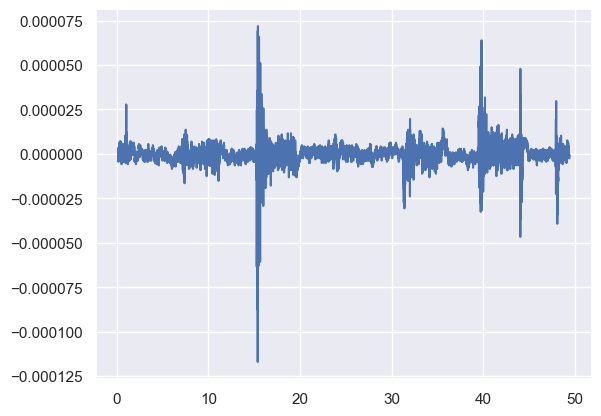

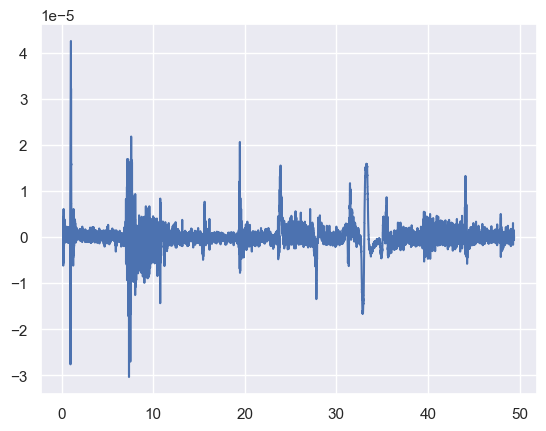

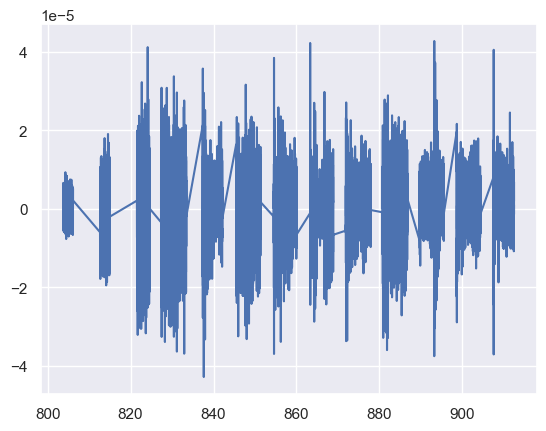

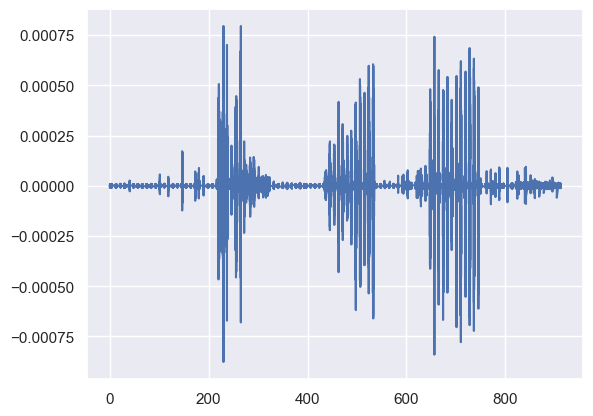

In [131]:
plt.plot(testing_data['Timestamp'],testing_data['Channel1'], label='Channel 1 (scaled)')
plt.show()

plt.plot(testing_data['Timestamp'],testing_data['Channel2'], label='Channel 2 (scaled)')
plt.show()

plt.plot(training_data[(training_data['Timestamp'] >= 800)]['Timestamp'],training_data[(training_data['Timestamp'] >= 800)]['Channel2'], label='Nina Channel 2 (scaled)')
plt.show()

plt.plot(training_data['Timestamp'],training_data['Channel8'], label='Nina Channel 8 (scaled)')
plt.show()

In [132]:
print(training_data['Channel2'].shape)
print(testing_data['Channel1'].shape)
print(training_data['Channel8'].shape)
print(testing_data['Channel2'].shape)

training_data.head(10)

(1106229,)
(71989,)
(1106229,)
(71989,)


,Channel2,Channel8,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
0,-2.786037e-07,-0.000004,0,0,0,1,0.0000
1,-1.285415e-06,-0.000004,0,0,0,1,0.0005
2,-3.970727e-06,-0.000004,0,0,0,1,0.0010
3,-4.306138e-06,-0.000004,0,0,0,1,0.0015
4,-6.131493e-07,-0.000003,0,0,0,1,0.0020
5,2.072740e-06,-0.000003,0,0,0,1,0.0025
6,2.073029e-06,-0.000004,0,0,0,1,0.0030
7,1.905418e-06,-0.000006,0,0,0,1,0.0035
8,2.745008e-06,-0.000006,0,0,0,1,0.0040
9,3.416698e-06,-0.000005,0,0,0,1,0.0045


In [133]:
testing_data.head(10)

,Timestamp,Channel1,Channel2,Gesture
0,0.161,-0.000003,-0.000003,0
1,0.161,-0.000003,-0.000003,0
2,0.161,-0.000003,-0.000003,0
3,0.162,-0.000003,-0.000003,0
4,0.162,-0.000002,-0.000004,0
5,0.162,-0.000003,-0.000004,0
6,0.162,-0.000003,-0.000004,0
7,0.163,-0.000003,-0.000004,0
8,0.163,-0.000004,-0.000004,0
9,0.163,-0.000004,-0.000005,0


## Features

In [102]:
# Take only selected mouvements and channels 2 & 8 for Ninapro data

# create empty dataframe to store the data
# emg_training = pd.DataFrame()
# for key, value in gesture_to_id.items():
#     mvmt = value
#     emg_training = pd.concat([emg_training, emg_windows[mvmt][:][:, [1, 7]]], axis=0)

# emg_windows[13][rep][:, channel_idx]
# emg_training = emg_rectified[:, [1, 7]] # Channel 2 and 8 (0-indexed)

emg_training = training_data[['Channel2', 'Channel8']].values
stimulus = training_data['Restimulus']
repetition = training_data['Rerepetition']
dataset, labels = build_dataset_from_ninapro(
    emg=emg_training,
    stimulus=stimulus,
    repetition=repetition,
    features= features_selected
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

Number of samples: 30, Number of features: 12, Number of channels: 2
dataset dimension: (30, 12)
labels dimension: (30,)


In [103]:
# Prepare the input data
emg_testing = testing_data[['Channel1', 'Channel2']].values  # Replace with your selected channels
stimulus_testing = testing_data['Gesture'].values
repetition_testing = np.ones(len(testing_data))  # Ensure this column exists in testing_data

# Define the features
features_selected = [mav, std, maxav, rms, wl, ssc]

# Extract features using the function
dataset_testing, labels_testing = build_dataset_from_ninapro(
    emg=emg_testing,
    stimulus=stimulus_testing,
    repetition=repetition_testing,
    features=features_selected
)

# Check the output
print(f"Testing dataset shape: {dataset_testing.shape}")
print(f"Testing labels shape: {labels_testing.shape}")

Number of samples: 0, Number of features: 12, Number of channels: 2
Testing dataset shape: (0, 12)
Testing labels shape: (0,)


In [104]:
# Parameters for windowing
window_size = 200  # Number of samples in a window
step_size = 50     # Step size for sliding window

# Restructure training data
training_features = []
training_labels = []

for start_idx in range(0, len(emg_training) - window_size + 1, step_size):
    # Extract the current window
    window = emg_training[start_idx:start_idx + window_size, :]
    
    # Extract features from the window
    features = [feature(window) for feature in features_selected]
    features = np.concatenate(features)  # Combine features into a single vector
    training_features.append(features)
    
    # Assign label based on the majority class in the window
    window_labels = stimulus[start_idx:start_idx + window_size]
    majority_label = np.bincount(window_labels).argmax()
    training_labels.append(majority_label)

# Convert to numpy arrays
training_features = np.array(training_features)
training_labels = np.array(training_labels)

In [105]:
testing_features = []
testing_labels = []

for start_idx in range(0, len(emg_testing) - window_size + 1, step_size):
    # Extract the current window
    window = emg_testing[start_idx:start_idx + window_size, :]
    
    # Extract features from the window
    features = [feature(window) for feature in features_selected]
    features = np.concatenate(features)  # Combine features into a single vector
    testing_features.append(features)
    
    # Assign label based on the majority class in the window
    window_labels = stimulus_testing[start_idx:start_idx + window_size]
    majority_label = np.bincount(window_labels).argmax()
    testing_labels.append(majority_label)

# Convert to numpy arrays
testing_features = np.array(testing_features)
testing_labels = np.array(testing_labels)

In [106]:
print(testing_data.shape, training_data.shape, testing_features.shape, training_features.shape)

(71989, 4) (1106229, 7) (1436, 12) (22121, 12)


## Training

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy score: 0.09401114206128133
Recall score: 0.14285714285714285
F1 score: 0.0245521505865236


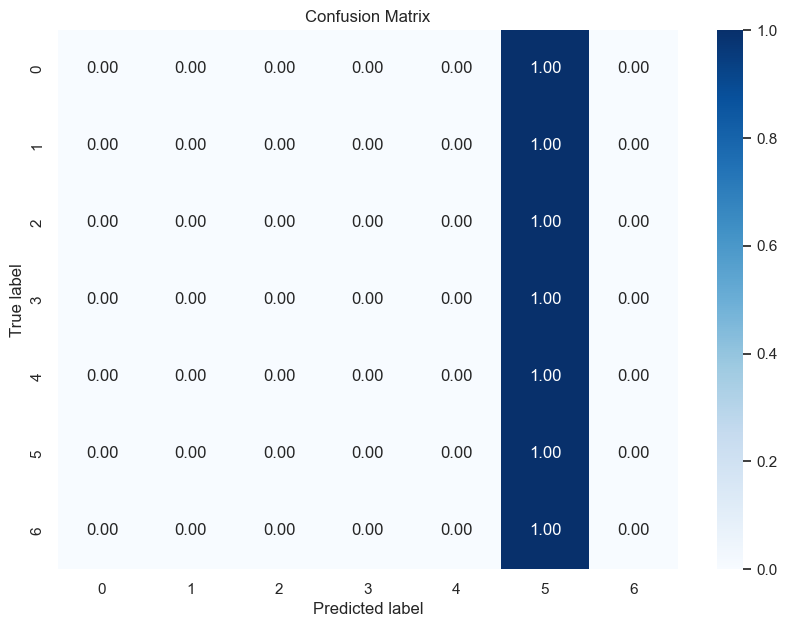

In [107]:
# Define the Random Forest model
rf = RandomForestClassifier()

# Hyperparameter optimization using Grid Search
param_grid = {
    # 'n_estimators': [50, 100, 200],
    # 'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(training_features, training_labels)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(training_features, training_labels)

# Evaluate the model
y_pred = best_rf.predict(testing_features)
accuracy = accuracy_score(testing_labels, y_pred)
print(f"Accuracy score: {accuracy}")
print(f"Recall score: {recall_score(testing_labels, y_pred, average='macro')}")
print(f"F1 score: {f1_score(testing_labels, y_pred, average='macro')}")

# Confusion matrix
confmat = confusion_matrix(testing_labels, y_pred, normalize="true")
plt.figure(figsize=(10, 7))
sns.heatmap(confmat, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

## Cross correlation

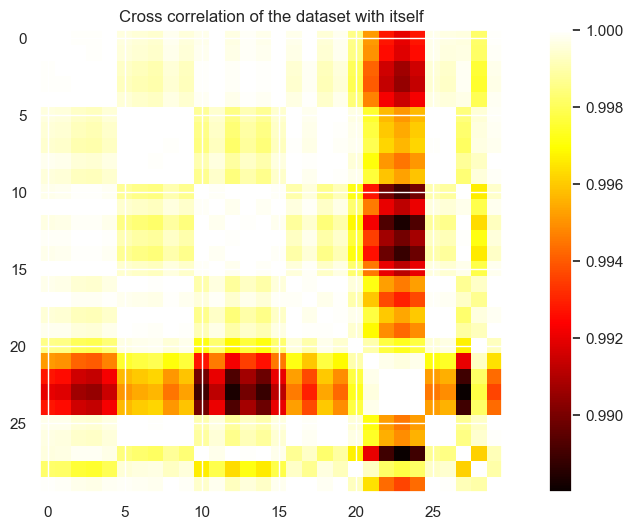

In [ ]:
# plot the cross correlation of the dataset with itself

plt.figure(figsize=(12, 6))
plt.title("Cross correlation of the dataset with itself")
plt.imshow(np.corrcoef(dataset), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# normal that every 5 labels are the same, so it's a good sanity check
